# Overview of triangulation precision dependencies

This research is a part of project "Handy" that is conducted by HSE Robotics Groups.
The aims of this research are the following:
- to determine the best placement of cameras around the table
- to measure precision fluctuations caused by various center-determing algorithms, segmentation errors and FOV

Let us assume that intrinsic parameters of the cameras are known to us with ideal precision. Also, cameras' positions relative to each other 
(parameters of stereo calibration) are also known with maximum precision.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.spatial.transform import Rotation
from scipy.ndimage import center_of_mass

from typing import Tuple, List

In [2]:
# let us introduce intrinsic parameters and assume that they provide zero reprojection error for an arbitrary image-world correlation

IMAGE_SIZE = (1920, 1200)
K_1 = np.array(
    [
        672.2824725267757,
        0,
        984.0472159818853,
        0,
        672.6886411532304,
        602.96669930345,
        0,
        0,
        1,
    ]
).reshape((3, 3))
distortion_coefs_1 = np.array(
    [
        -0.09715103386082896,
        0.06788948036532018,
        -0.0007157453506997161,
        0.0003048354358359307,
        -0.003636308978789861,
    ]
)
K_2 = np.array(
    [
        685.7143789189881,
        0,
        991.0247637161314,
        0,
        686.3020333004097,
        601.2442243349392,
        0,
        0,
        1,
    ]
).reshape((3, 3))
distortion_coefs_2 = np.array(
    [
        -0.09781628655937251,
        0.07153618281495966,
        -0.001066517414175782,
        0.0004679942401339674,
        -0.003645360450147547,
    ]
)

# other constant and measurements
TABLE_LENGTH = 2.74
TABLE_WIDTH = 1.525

In [3]:
from typing import Any


class Transformation:
    def __init__(self, R, t):
        self.R = R
        self.t = t
        self.R_inv = np.linalg.inv(self.R)

    def __call__(self, point):
        return self.R @ point + self.t

    def transform(self, point):
        return self(point)

    def inverse_transform(self, point):
        return self.R_inv @ (point - self.t)

    # right transformation is applied first
    def __mult__(self, other):
        return Transformation(self.R @ other.R, self.t + other.t)

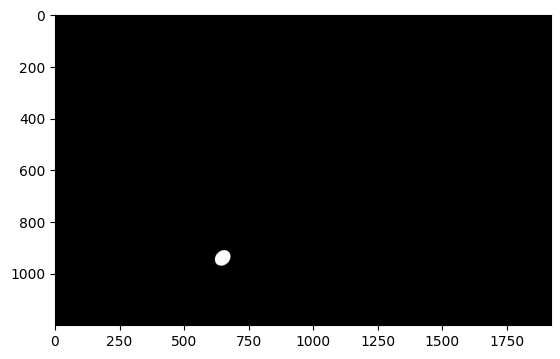

In [4]:
def validate_image_point(point):
    return (
        point[0] < 0
        or point[0] >= IMAGE_SIZE[0]
        or point[1] < 0
        or point[1] >= IMAGE_SIZE[1]
    )
    # raise ValueError(f"Invalid image point coordinates: out of FOV?")


def project_point_to_image(point, transformation, camera_matrix):
    return camera_matrix @ transformation(point)


def normilise_image_point(point, camera_matrix):
    x_normalised = (point[0] - camera_matrix[0, 2]) / camera_matrix[0, 0]
    y_normalised = (point[1] - camera_matrix[1, 2]) / camera_matrix[1, 1]
    return np.array([x_normalised, y_normalised, 1]).reshape(3, 1)


def project_sphere_to_image(
    center: Tuple[int], radius: int, camera_matrix: np.ndarray, world2cam
) -> np.ndarray:
    image = np.zeros(IMAGE_SIZE[::-1])
    center = np.array(center)
    camera_matrix_inv = np.linalg.inv(camera_matrix)

    # projecting center and some edge point to approximate radius after projection
    projected_center = camera_matrix @ center.reshape((3, 1))
    projected_center /= projected_center[2]
    projected_edge_point = camera_matrix @ (center + np.array([radius, 0, 0])).reshape(
        (3, 1)
    )
    projected_edge_point /= projected_edge_point[2]
    approx_projected_radius = np.linalg.norm(
        projected_edge_point - projected_center, ord=2
    )

    # calculating bounding box for calculations with 1.5 margin
    x_start = int(max(0, projected_center[0].item() - 1.5 * approx_projected_radius))
    y_start = int(max(0, projected_center[1].item() - 1.5 * approx_projected_radius))
    x_stop = int(
        min(IMAGE_SIZE[0], projected_center[0].item() + 1.5 * approx_projected_radius)
    )
    y_stop = int(
        min(IMAGE_SIZE[1], projected_center[1].item() + 1.5 * approx_projected_radius)
    )

    for x in range(x_start, x_stop):
        for y in range(y_start, y_stop):
            # back project image point
            world_ray = camera_matrix_inv @ np.array([x, y, 1]).reshape((3, 1))
            # measure distance from the sphere center
            distance = np.linalg.norm(
                np.cross(world_ray.flatten(), center), ord=2
            ) / np.linalg.norm(world_ray, ord=2)
            # if back-projected ray intersects with the sphere, paint the pixel in the mask
            if distance <= radius:
                image[y, x] = 1
    return image


image = project_sphere_to_image((-0.25, 0.25, 0.5), 0.02, K_1, None)
plt.imshow(image, cmap="gray")
plt.show()

In [5]:
def triangulate_position(
    points_by_view, world2cam, cam2cam, camera_matrix_1, camera_matrix_2
):
    proj_1 = camera_matrix_1 @ world2cam
    proj_2 = camera_matrix_2 @ cam2cam @ world2cam
    # TODO save 4D points?
    return cv2.triangulatePoints(
        proj_1, proj_2, points_by_view[:, 0, :], points_by_view[:, 1, :]
    )[:, :3]

In [6]:
def get_bbox(mask: np.ndarray) -> List[float]:
    # x_min, y_min, x_max, y_max
    horizontal_indicies = np.where(np.any(mask, axis=0))[0]
    vertical_indicies = np.where(np.any(mask, axis=1))[0]
    x1, x2 = horizontal_indicies[[0, -1]]
    y1, y2 = vertical_indicies[[0, -1]]
    bbox = list(map(float, [x1, y1, x2, y2]))
    return bbox


def get_mask_center(mask):
    bbox = get_bbox(mask)
    centroid_x = (bbox[0] + bbox[2]) / 2
    centroid_y = (bbox[1] + bbox[3]) / 2
    return np.array([centroid_x, centroid_y])


def get_mask_centroid(mask):
    return np.array(center_of_mass(mask))

In [7]:
def evaluate_precision(sphere_centers, triangulated_points):
    errors = sphere_centers - triangulated_points
    print("precision of triangulated points:")
    print(np.mean(errors * errors))

In [9]:
def evaluate_camera_position(
    world2master: Transformation,
    master2second: Transformation,
    center_extranctor,
    camera_matrix_1,
    camera_matrix_2,
):
    sphere_centers = np.row_stack(
        (
            np.linspace(-TABLE_LENGTH / 2, TABLE_LENGTH / 2, 10),
            np.linspace(-TABLE_WIDTH / 2, TABLE_WIDTH / 2, 10),
        )
    )

    points = []
    world2second = master2second @ world2master
    for i in range(sphere_centers.shape[1]):
        mask_1 = project_sphere_to_image(sphere_centers[:, i], 0.02, K_1, world2master)
        mask_2 = project_sphere_to_image(sphere_centers[:, i], 0.02, K_2, world2second)
        points.append((center_extranctor(mask_1), center_extranctor(mask_2)))
    triangulated_points = triangulate_position(
        points, world2master, master2second, camera_matrix_1, camera_matrix_2
    )
    print(f"triangulated_points shape is {triangulated_points.shape}")

    evaluate_precision(sphere_centers, triangulated_points)
    print("evalution complete")

# main test: opposite camera placement
world2master = Transformation(Rotation.from_euler("xyz", [], degrees=True).as_matrix(), np.array([0, 0, 0]))
master2second = Transformation(Rotation.from_euler("xyz", [], degrees=True).as_matrix(), np.array([0, 0, 0]))
evaluate_camera_position(world2master, master2second, K_1, K_2)
